## Обучим модель предсказания типа вакансии (DA или DS)

Хотим обучить модель градиентного бустинга(Catboost) для классификации на DA и DS, по навыкам вакансии.

In [8]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt
import shap
import catboost

### Загрузка данных и удаление пропущенных значений

In [3]:
# Загружаем данные о вакансиях из CSV-файла в DataFrame
vacancies = pd.read_csv('data/vacancies_bi.csv')

# Удаляем строки, где отсутствуют данные в столбце 'skills'
vacancies.dropna(subset='skills', inplace=True)

# Сбрасываем индекс DataFrame, чтобы он шел последовательно после удаления строк
vacancies.reset_index(drop=True, inplace=True)

# Преобразуем строку с навыками в список, разделяя навыки по запятой
vacancies['skills'] = vacancies['skills'].str.split(', ')

# Выводим столбец 'skills', который теперь содержит списки навыков
vacancies['skills']


0       [финансовый анализ, анализ финансовых показате...
1       [data mining, статистический анализ, анализ би...
2       [g, кредитные риски, портфельные риски, статис...
3       [анализ данных, data catalog, data governance,...
4       [writing articles, fluent english, data mining...
                              ...                        
1282    [bi, pytorch, статистика, etl, numpy, python, ...
1283    [bi, python, pandas, oracle, hadoop, субд, pos...
1284    [numpy, pandas, прогнозирование, hadoop, sql, ...
1285    [numpy, python, pandas, прогнозирование, docke...
1286                                            [bi, sql]
Name: skills, Length: 1287, dtype: object

### Векторизация списка навыков

Будем исползовать идею Bag Of Word. Каждая строка нашей матрицы будет соответствовать вакансии, а каждый столбец матрицы будет соответствовать навыку. В результате мы получим матрицу("количество вакансий" x "количество навыков"). На пересечении вакансии и слова будет стоять 1 если навык присутствует в вакансии, 0 в обратном случае.

In [11]:
# Создаем счетчик для подсчета количества каждого навыка во всех вакансиях
features = Counter()

# Обновляем счетчик, добавляя навыки из каждой вакансии
for vac in vacancies.skills:
    features.update(vac)

# Получаем список 21 самого часто встречающегося навыка
features = [tup[0] for tup in features.most_common(21)]

# Удаляем из списка навык 'анализ данных', так как он слишком общий
features.remove('анализ данных')

# Создаем словарь, который сопоставляет каждый навык с его индексом
feature_to_index = {feature: i for i, feature in enumerate(features)}

# Инициализируем матрицу признаков нулями для всех вакансий и навыков
X = [[0] * len(features) for i in range(vacancies['skills'].size)]

# Преобразуем матрицу признаков в DataFrame для удобства работы
X = pd.DataFrame(X, columns=features)

# Заполняем матрицу признаков: устанавливаем 1, если навык присутствует в вакансии
for i, lst in enumerate(vacancies['skills']):
    for skill in lst:
        if skill in set(features):
            X.iloc[i, feature_to_index[skill]] = 1


In [12]:
# преобразуем аналитиков в отрицательный класс, а датасаентистов в положительный
classes = {'da': -1, 'ds': 1}
vacancies['name_type'] = vacancies['name_type'].map(classes)

In [13]:
# посмотрим баланс классов
vacancies['name_type'].value_counts() / len(vacancies)

name_type
-1    0.685315
 1    0.314685
Name: count, dtype: float64

In [14]:
# разделим нашу выборку на тренировочную и валидационную и проверим баланс классов
X_train, X_val, y_train, y_val = train_test_split(
    X, vacancies['name_type'], 
    test_size=0.3, 
    random_state=42, 
    stratify=vacancies['name_type']
)
y_train.value_counts() / len(y_train), y_val.value_counts() / len(y_val)

(name_type
 -1    0.685556
  1    0.314444
 Name: count, dtype: float64,
 name_type
 -1    0.684755
  1    0.315245
 Name: count, dtype: float64)

Отлично баланс классов не поменялся

### Обучение модели

In [15]:
boosting_model = catboost.CatBoostClassifier(
    random_seed=123,
    learning_rate=0.001,
    iterations=5000,
    depth=5,
    l2_leaf_reg=3
)

boosting_model.fit(X_train, y_train,
                   eval_set=(X_val, y_val),
                   verbose=100
                  )

0:	learn: 0.6923665	test: 0.6923604	best: 0.6923604 (0)	total: 1.22ms	remaining: 6.09s
100:	learn: 0.6149586	test: 0.6152430	best: 0.6152430 (100)	total: 78.7ms	remaining: 3.82s
200:	learn: 0.5545483	test: 0.5546474	best: 0.5546474 (200)	total: 149ms	remaining: 3.55s
300:	learn: 0.5057157	test: 0.5065080	best: 0.5065080 (300)	total: 220ms	remaining: 3.44s
400:	learn: 0.4672352	test: 0.4680391	best: 0.4680391 (400)	total: 301ms	remaining: 3.46s
500:	learn: 0.4365462	test: 0.4379022	best: 0.4379022 (500)	total: 374ms	remaining: 3.36s
600:	learn: 0.4121969	test: 0.4140859	best: 0.4140859 (600)	total: 448ms	remaining: 3.27s
700:	learn: 0.3911115	test: 0.3940972	best: 0.3940972 (700)	total: 523ms	remaining: 3.21s
800:	learn: 0.3746606	test: 0.3785384	best: 0.3785384 (800)	total: 595ms	remaining: 3.12s
900:	learn: 0.3601191	test: 0.3652778	best: 0.3652778 (900)	total: 668ms	remaining: 3.04s
1000:	learn: 0.3477944	test: 0.3544443	best: 0.3544443 (1000)	total: 742ms	remaining: 2.96s
1100:	lear

### Посмотрим на качество нашей модели

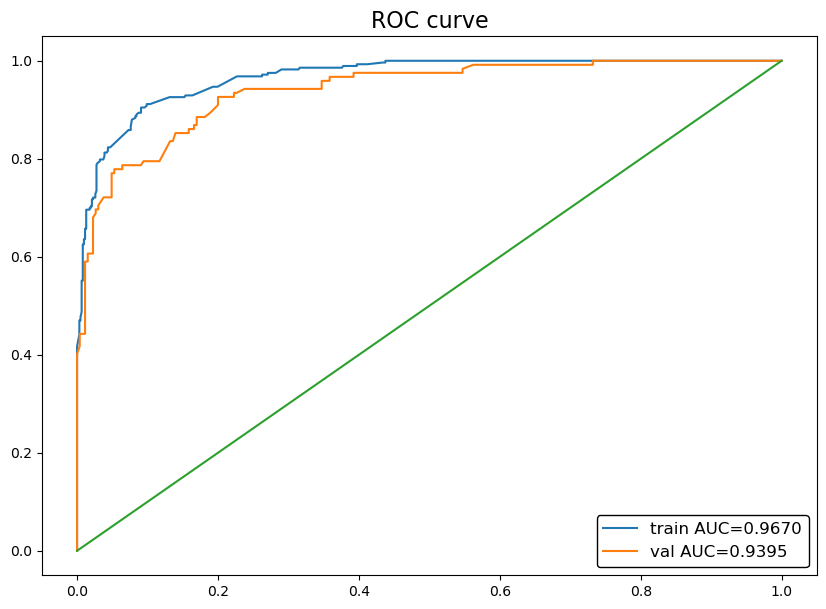

In [16]:
y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_val_predicted = boosting_model.predict_proba(X_val)[:, 1]

train_auc = roc_auc_score(y_train, y_train_predicted)
val_auc = roc_auc_score(y_val, y_val_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_val, y_val_predicted)[:2], label='val AUC={:.4f}'.format(val_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.title('ROC curve', fontsize=16)
plt.show()

Качество для наших целей нас полностью устраивает сохраним модель.

In [19]:
boosting_model.save_model('boosting_model.cbm', format='cbm')

In [17]:
explainer = shap.TreeExplainer(boosting_model)
shap_values = explainer(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


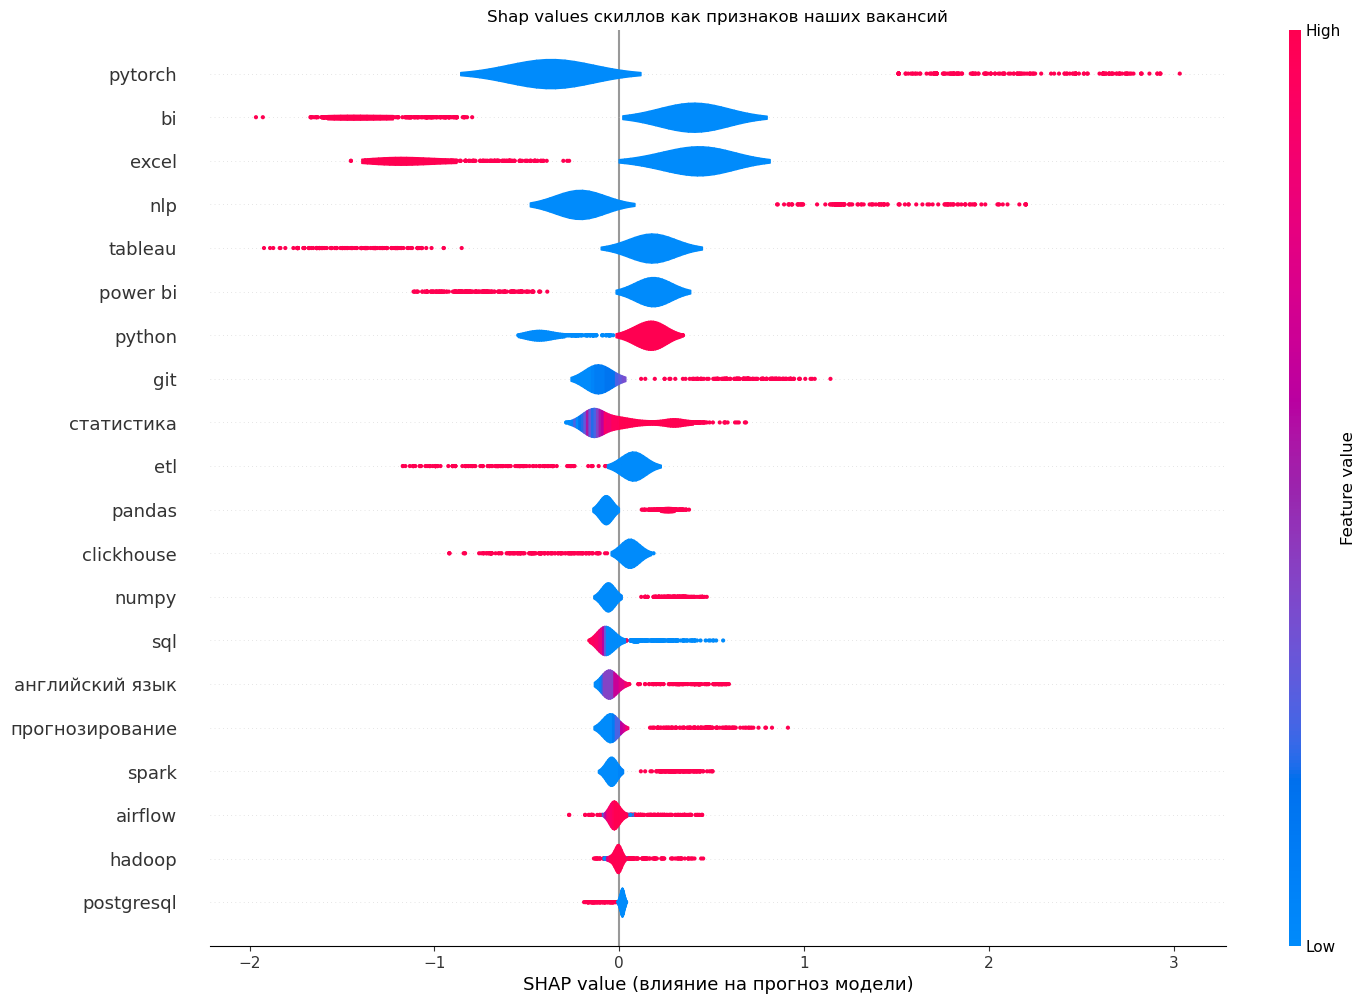

In [20]:
ax = shap.summary_plot(shap_values, X, max_display=30, plot_size=[15, 10], plot_type="violin", show=False)
plt.title("Shap values скиллов как признаков наших вакансий")
plt.xlabel('SHAP value (влияние на прогноз модели)')
plt.show()
